# Automatic License Plate Recognition (ALPR)

### 1️⃣ Introduction & Problem Statement


Automatic License Plate Recognition (ALPR) is a crucial technology used in various applications such as traffic management, law enforcement, and automated toll collection. The ability to accurately detect and recognize characters from vehicle license plates is essential for enhancing security and operational efficiency.

In this project, our goal is to develop an AI-driven solution for license plate detection and character recognition using YOLOv8 for object detection and OCR models for text extraction.

##### Project Objectives:
- License Plate Detection – Identify and localize license plates within images.
- Character Recognition – Extract and classify the characters present on the detected license plates.

##### Project Workflow:
- Data Preprocessing – Cleaning and preparing image data for model training.
- Exploratory Data Analysis (EDA) – Understanding dataset characteristics and identifying patterns.
- Model Building – Training YOLOv8 for plate detection and integrating OCR for character recognition.
- Evaluation – Assessing the model's accuracy and performance on test images.
- Result Submission – Formatting the final predictions as per the required submission format.

This work showcases the practical application of computer vision and deep learning in real-world scenarios, demonstrating our ability to build and optimize models for image processing tasks.









#### Importing Essential Libraries

In [37]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import glob
import easyocr
import numpy as np
import re

#### Setting up the files 

In [ ]:
# Defining paths
base_path = "D:/SoulPageIT"  
detection_folder = os.path.join(base_path, "license_plates_detection_train")
recognition_folder = os.path.join(base_path, "license_plates_recognition_train")
detection_csv = os.path.join(base_path, "Licplatesdetection_train.csv")
recognition_csv = os.path.join(base_path, "Licplatesrecognition_train.csv")


In [ ]:
# Loading CSV files
df_detection = pd.read_csv(detection_csv)
df_recognition = pd.read_csv(recognition_csv)


### 2️⃣ Exploratory Data Analysis (EDA)

In [ ]:
# Displaying first few rows
print("🔹 Detection CSV:")
print(df_detection.head())

print("\n🔹 Recognition CSV:")
print(df_recognition.head())

🔹 Detection CSV:
    img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222

🔹 Recognition CSV:
    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979


In [ ]:
# Checking number of images in each folder
print("\n🔹 Number of detection images:", len(os.listdir(detection_folder)))
print("🔹 Number of recognition images:", len(os.listdir(recognition_folder)))


🔹 Number of detection images: 900
🔹 Number of recognition images: 910


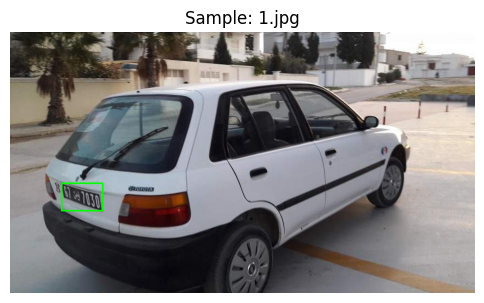

In [6]:
def visualize_sample(image_name):
    # Load image
    image_path = os.path.join(detection_folder, image_name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"❌ Error: {image_name} not found.")
        return
    
    # Get bounding box from CSV
    bbox = df_detection[df_detection["img_id"] == image_name]
    for _, row in bbox.iterrows():
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # Convert image to RGB (for proper display in matplotlib)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display image
    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.title(f"Sample: {image_name}")
    plt.axis("off")
    plt.show()

# Test visualization
sample_image = df_detection["img_id"].iloc[0]  # First image from CSV
visualize_sample(sample_image)


#### 3️⃣ Data Preprocessing

In [ ]:


# Defining YOLO label folder
yolo_labels_folder = os.path.join(base_path, "yolo_labels")
os.makedirs(yolo_labels_folder, exist_ok=True)

def convert_to_yolo_format(df, image_folder, label_folder):
    for index, row in df.iterrows():
        image_name = row["img_id"]
        image_path = os.path.join(image_folder, image_name)

        # Read image to get dimensions
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Skipping {image_name} (Image not found)")
            continue
        
        img_h, img_w, _ = image.shape

        # Convert bbox to YOLO format
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        # YOLO class_id (0 for license plate)
        yolo_annotation = f"0 {x_center} {y_center} {width} {height}\n"

        # Save annotation file
        label_file = os.path.join(label_folder, image_name.replace(".jpg", ".txt"))
        with open(label_file, "w") as file:
            file.write(yolo_annotation)

convert_to_yolo_format(df_detection, detection_folder, yolo_labels_folder)
print("✅ YOLO annotations created successfully!")


✅ YOLO annotations created successfully!


#### 4️⃣ Splitting Data for Training and Validation

In [ ]:


# Creating directories
yolo_dataset_path = os.path.join(base_path, "yolo_dataset")
images_train = os.path.join(yolo_dataset_path, "images/train")
images_val = os.path.join(yolo_dataset_path, "images/val")
labels_train = os.path.join(yolo_dataset_path, "labels/train")
labels_val = os.path.join(yolo_dataset_path, "labels/val")

for folder in [images_train, images_val, labels_train, labels_val]:
    os.makedirs(folder, exist_ok=True)

# Spliting data into train & val (80-20 split)
image_files = os.listdir(detection_folder)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Moving images & labels
for file in train_files:
    shutil.copy(os.path.join(detection_folder, file), images_train)
    shutil.copy(os.path.join(yolo_labels_folder, file.replace(".jpg", ".txt")), labels_train)

for file in val_files:
    shutil.copy(os.path.join(detection_folder, file), images_val)
    shutil.copy(os.path.join(yolo_labels_folder, file.replace(".jpg", ".txt")), labels_val)

print("✅ Dataset is ready for YOLO training!")


✅ Dataset is ready for YOLO training!


#### 5️⃣ License Plate Detection using YOLOv8

In [ ]:


# Loading YOLOv8 model
model = YOLO("yolov8n.pt")  # Using YOLOv8 nano for speed

# Training model
model.train(data="D:/SoulPageIT/data.yaml", epochs=50, imgsz=640, batch=16, device="cpu")


Ultralytics 8.3.78  Python-3.12.0 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/SoulPageIT/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

train: Scanning D:\SoulPageIT\yolo_dataset\labels\train... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:03<00:00, 222.46it/s]


train: New cache created: D:\SoulPageIT\yolo_dataset\labels\train.cache


val: Scanning D:\SoulPageIT\yolo_dataset\labels\val... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 220.42it/s]

val: New cache created: D:\SoulPageIT\yolo_dataset\labels\val.cache


Plotting labels to D:\projects\runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to D:\projects\runs\detect\train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.181       2.32      1.076         36        640: 100%|██████████| 45/45 [06:09<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.75s/it]

                   all        180        180          1     0.0241      0.881      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.197      1.469       1.04         17        640: 100%|██████████| 45/45 [06:06<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.49s/it]

                   all        180        180      0.939      0.942      0.977      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.172      1.228      1.025         25        640: 100%|██████████| 45/45 [06:10<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.83s/it]

                   all        180        180      0.922      0.878      0.927      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.134       1.09      1.026         28        640: 100%|██████████| 45/45 [06:13<00:00,  8.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

                   all        180        180      0.974      0.933      0.981      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.137     0.9492      1.024         33        640: 100%|██████████| 45/45 [06:23<00:00,  8.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.44s/it]

                   all        180        180      0.916      0.961      0.964      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.119     0.8778       1.01         29        640: 100%|██████████| 45/45 [06:11<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.46s/it]

                   all        180        180      0.978      0.982      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G       1.09     0.8055      1.007         30        640: 100%|██████████| 45/45 [06:12<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.58s/it]

                   all        180        180      0.978       0.95      0.991      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.111     0.7798       1.01         24        640: 100%|██████████| 45/45 [06:15<00:00,  8.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.51s/it]

                   all        180        180      0.957      0.989       0.99      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G       1.03     0.7199     0.9855         33        640: 100%|██████████| 45/45 [06:15<00:00,  8.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.47s/it]

                   all        180        180      0.989      0.955      0.993      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G          1     0.7071     0.9883         28        640: 100%|██████████| 45/45 [06:13<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.46s/it]

                   all        180        180      0.949      0.983      0.985      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.024     0.6906     0.9844         22        640: 100%|██████████| 45/45 [06:10<00:00,  8.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

                   all        180        180      0.958      0.967      0.989      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.011     0.6725     0.9791         29        640: 100%|██████████| 45/45 [06:11<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.45s/it]

                   all        180        180      0.974      0.989      0.994      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.009     0.6303     0.9673         32        640: 100%|██████████| 45/45 [06:13<00:00,  8.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.42s/it]

                   all        180        180      0.972      0.972      0.993      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.9928     0.6187     0.9665         23        640: 100%|██████████| 45/45 [06:14<00:00,  8.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.50s/it]

                   all        180        180      0.957      0.983      0.991      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      0.971     0.6027      0.964         33        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.45s/it]

                   all        180        180      0.974      0.989      0.994      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.9612     0.5978     0.9637         23        640: 100%|██████████| 45/45 [06:08<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.49s/it]

                   all        180        180      0.994      0.994      0.995      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      0.987     0.5989     0.9649         32        640: 100%|██████████| 45/45 [06:11<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.68s/it]

                   all        180        180      0.994      0.993      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.9641     0.5802      0.948         26        640: 100%|██████████| 45/45 [06:07<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]

                   all        180        180      0.983      0.989      0.993      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.9377     0.5431     0.9436         31        640: 100%|██████████| 45/45 [06:07<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.46s/it]

                   all        180        180      0.993      0.994      0.995       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.9483      0.558     0.9516         28        640: 100%|██████████| 45/45 [06:06<00:00,  8.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        180        180          1      0.983      0.995      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.8928     0.5276     0.9339         27        640: 100%|██████████| 45/45 [06:10<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.41s/it]

                   all        180        180      0.987          1      0.995      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.9677     0.5511     0.9455         29        640: 100%|██████████| 45/45 [06:06<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.25s/it]

                   all        180        180      0.978      0.996      0.994      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9479     0.5402      0.953         29        640: 100%|██████████| 45/45 [06:09<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.31s/it]

                   all        180        180      0.987      0.989      0.994      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.8818     0.5076      0.925         25        640: 100%|██████████| 45/45 [06:39<00:00,  8.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.55s/it]

                   all        180        180      0.988      0.994      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9271     0.5373      0.948         36        640: 100%|██████████| 45/45 [06:07<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        180        180      0.994      0.999      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.9019     0.5191     0.9385         35        640: 100%|██████████| 45/45 [06:04<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.32s/it]

                   all        180        180      0.994          1      0.995       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.8804     0.5051     0.9301         30        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.49s/it]

                   all        180        180      0.992          1      0.995      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.8848     0.5057     0.9343         29        640: 100%|██████████| 45/45 [06:08<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.53s/it]

                   all        180        180      0.984      0.998      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.8711     0.4922      0.931         31        640: 100%|██████████| 45/45 [06:04<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.22s/it]

                   all        180        180      0.973      0.999      0.994      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.8809     0.4916      0.933         26        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.49s/it]

                   all        180        180      0.999          1      0.995      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      0.854     0.4872     0.9255         23        640: 100%|██████████| 45/45 [06:04<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.26s/it]

                   all        180        180      0.994          1      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.8637     0.4748     0.9221         24        640: 100%|██████████| 45/45 [06:07<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.89s/it]

                   all        180        180          1          1      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.8387     0.4635     0.9187         29        640: 100%|██████████| 45/45 [06:13<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]

                   all        180        180      0.992          1      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.8375     0.4574      0.916         27        640: 100%|██████████| 45/45 [06:26<00:00,  8.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.51s/it]

                   all        180        180      0.999          1      0.995      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.8118     0.4362     0.9057         32        640: 100%|██████████| 45/45 [06:11<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.44s/it]

                   all        180        180          1          1      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.8107     0.4584     0.9062         36        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.43s/it]

                   all        180        180      0.999          1      0.995      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.8107     0.4511     0.9106         40        640: 100%|██████████| 45/45 [06:05<00:00,  8.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        180        180      0.999          1      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.8186     0.4493     0.9069         33        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.39s/it]

                   all        180        180          1          1      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7883     0.4245     0.9009         29        640: 100%|██████████| 45/45 [06:11<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

                   all        180        180          1          1      0.995      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7959     0.4235     0.9035         28        640: 100%|██████████| 45/45 [06:10<00:00,  8.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.50s/it]

                   all        180        180      0.999          1      0.995      0.805


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.7522     0.4013     0.8858         16        640: 100%|██████████| 45/45 [06:09<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.65s/it]

                   all        180        180      0.994          1      0.995      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.7266     0.3838     0.8756         16        640: 100%|██████████| 45/45 [06:08<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.44s/it]

                   all        180        180      0.994          1      0.995       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.7174      0.378     0.8828         16        640: 100%|██████████| 45/45 [06:10<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.50s/it]

                   all        180        180      0.998          1      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.7085     0.3775      0.885         16        640: 100%|██████████| 45/45 [06:09<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        180        180      0.997          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.7037     0.3695     0.8807         16        640: 100%|██████████| 45/45 [06:07<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.52s/it]

                   all        180        180      0.999          1      0.995      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.6874     0.3627     0.8605         16        640: 100%|██████████| 45/45 [06:09<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.85s/it]

                   all        180        180      0.999          1      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.6769     0.3617     0.8707         16        640: 100%|██████████| 45/45 [06:13<00:00,  8.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.54s/it]

                   all        180        180      0.999          1      0.995      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.6675     0.3464     0.8628         16        640: 100%|██████████| 45/45 [06:14<00:00,  8.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.47s/it]

                   all        180        180      0.999          1      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.6815     0.3517     0.8581         16        640: 100%|██████████| 45/45 [06:08<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.53s/it]

                   all        180        180      0.999          1      0.995      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.6428     0.3425     0.8616         16        640: 100%|██████████| 45/45 [06:09<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.27s/it]

                   all        180        180      0.999          1      0.995      0.818



50 epochs completed in 5.564 hours.
Optimizer stripped from D:\projects\runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from D:\projects\runs\detect\train6\weights\best.pt, 6.2MB

Validating D:\projects\runs\detect\train6\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.0 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:22<00:00,  3.83s/it]


                   all        180        180      0.999          1      0.995      0.829
Speed: 3.0ms preprocess, 114.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to D:\projects\runs\detect\train6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000242255AE420>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [ ]:
# Loading the best trained model
model = YOLO("D:/projects/runs/detect/train6/weights/best.pt")



WARNING  Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'




image 1/1 D:\SoulPageIT\license_plates_detection_train\4.jpg: 640x480 1 license_plate, 124.8ms
Speed: 7.3ms preprocess, 124.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to D:\projects\runs\detect\predict3


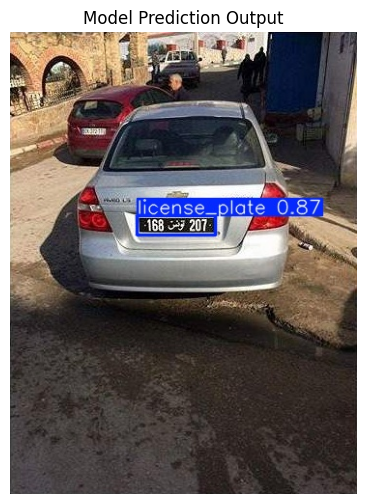

In [ ]:


# Path to your image 
image_path = r"D:\projects\runs\detect\predict3\4.jpg" 

# Load the image
image = cv2.imread(image_path)

# Convert BGR to RGB (OpenCV loads images in BGR format, while Matplotlib uses RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")  # Hide axis
plt.title("Model Detection Output")
plt.show()


In [ ]:


# Load the trained model
model = YOLO("D:/projects/runs/detect/train6/weights/best.pt")

# Define the test folder
test_folder = r"D:/SoulPageIT/test/test"  # Path where test images are stored
output_folder = r"D:/projects/runs/detect/predict_test"  # Custom folder for predictions

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get all image files in the test folder
image_files = glob.glob(os.path.join(test_folder, "*.jpg"))

if not image_files:
    print("⚠️ No images found in test folder! Check the path:", test_folder)

# Run inference and explicitly set save directory
for img_path in image_files:
    results = model(img_path, save=True, project=output_folder, name="results")

# Check where predictions are saved
predicted_images_path = os.path.join(output_folder, "results", "predict")
predicted_images = glob.glob(os.path.join(predicted_images_path, "*.jpg"))[:5]

if not predicted_images:
    print("⚠️ No predicted images found! Check if YOLO is detecting anything.")
else:
    print(f"✅ Found {len(predicted_images)} predicted images in {predicted_images_path}")




image 1/1 D:\SoulPageIT\test\test\1000.jpg: 448x640 1 license_plate, 110.2ms
Speed: 5.4ms preprocess, 110.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
Results saved to D:\projects\runs\detect\predict_test\results

image 1/1 D:\SoulPageIT\test\test\1001.jpg: 640x384 1 license_plate, 104.7ms
Speed: 3.6ms preprocess, 104.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to D:\projects\runs\detect\predict_test\results2

image 1/1 D:\SoulPageIT\test\test\1002.jpg: 640x480 1 license_plate, 100.6ms
Speed: 2.5ms preprocess, 100.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)
Results saved to D:\projects\runs\detect\predict_test\results3

image 1/1 D:\SoulPageIT\test\test\1003.jpg: 384x640 1 license_plate, 98.7ms
Speed: 2.7ms preprocess, 98.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to D:\projects\runs\detect\predict_test\results4

image 1/1 D:\SoulPageIT\test\test\1004.jpg: 64

✅ Found 5 predicted images.


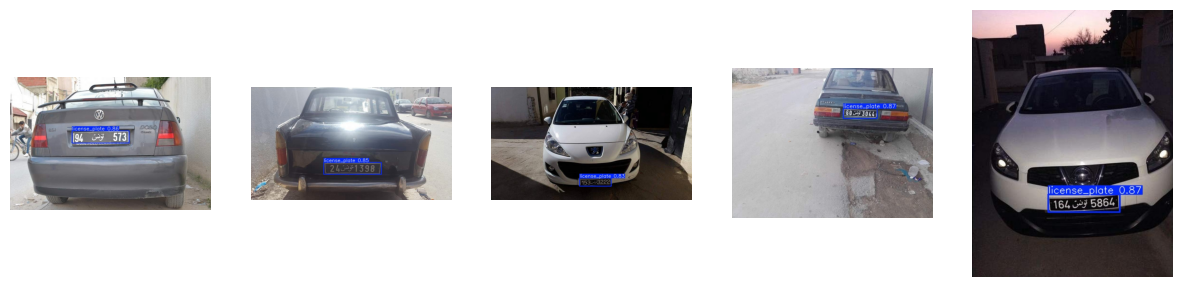

In [ ]:


# Define the base output folder where predictions are saved
output_folder = r"D:/projects/runs/detect/predict_test"

# Find all results folders
results_folders = glob.glob(os.path.join(output_folder, "results*"))

# Collect all predicted images from multiple result folders
predicted_images = []
for folder in results_folders:
    predicted_images.extend(glob.glob(os.path.join(folder, "*.jpg")))

# Take only the first 5 images for display
predicted_images = predicted_images[:5]

if not predicted_images:
    print("⚠️ No predicted images found! Check output folder:", output_folder)
else:
    print(f"✅ Found {len(predicted_images)} predicted images.")

# Plot results if images are available
if predicted_images:
    fig, axes = plt.subplots(1, len(predicted_images), figsize=(15, 5))

    if len(predicted_images) == 1:  # Handle single image case
        axes = [axes]

    for ax, img_path in zip(axes, predicted_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")

    plt.show()


#### 6️⃣ Character Recognition using OCR

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 384x640 1 license_plate, 134.8ms
Speed: 3.6ms preprocess, 134.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

🔹 Detected License Plate:
ا632   توىن 123|


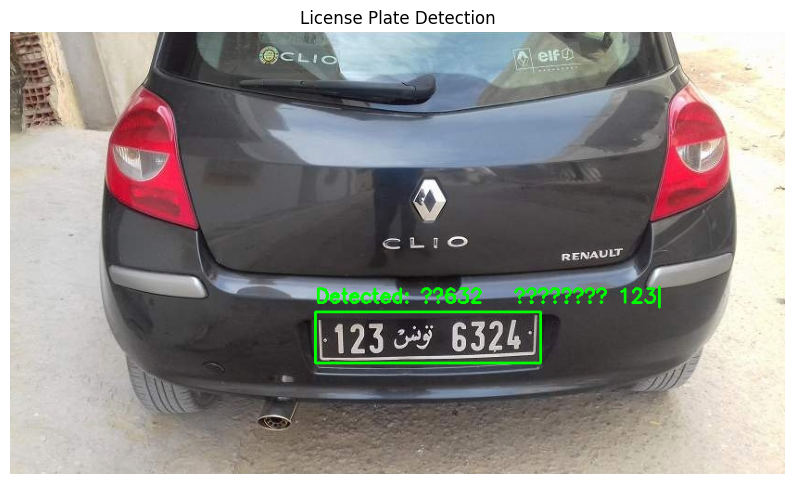

In [ ]:
# Initialize EasyOCR reader for Arabic & English
reader = easyocr.Reader(['ar', 'en'])
# Load the image
image_path = "D:/SoulPageIT/test/test/904.jpg" 
image = cv2.imread(image_path)

# Run YOLO model on the image
results = model(image)

detected_license_plates = []

# Loop through detected objects
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
        license_plate = image[y1:y2, x1:x2]  # Crop the license plate

        # Preprocessing for better OCR
        gray = cv2.cvtColor(license_plate, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)  # Reduce noise
        _, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Improve contrast

        # OCR detection
        results = reader.readtext(binary)

        # Extract text
        extracted_text = " ".join([res[1] for res in results])

        # Extract numbers & Arabic words separately
        numbers = re.findall(r'\d+', extracted_text)
        arabic_text = re.findall(r'[\u0600-\u06FF]+', extracted_text)

        # Ensure correct format: (first number) (Arabic word) (last number)
        if len(numbers) == 2 and len(arabic_text) == 1:
            final_text = f"{numbers[0]} {arabic_text[0]} {numbers[1]}"
        else:
            final_text = extracted_text  # Fallback in case of errors

        detected_license_plates.append(final_text)

        # Draw bounding box & detected text
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"Detected: {final_text}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Print detected license plate
print("\n🔹 Detected License Plate:")
for plate in detected_license_plates:
    print(plate)  # Should output: "123 تونس 6324"

# Display result using Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("License Plate Detection")
plt.show()



Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 384x640 1 license_plate, 185.5ms
Speed: 10.0ms preprocess, 185.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

🔹 Detected License Plate:
131 تونىن 1396


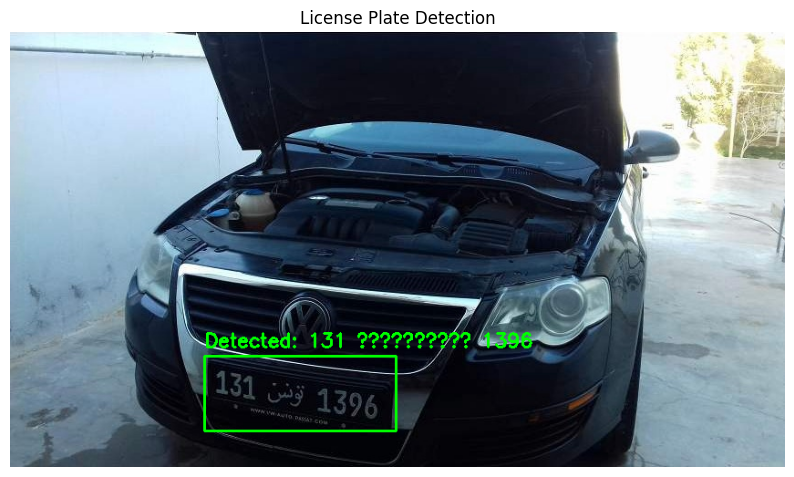

In [ ]:
# Initialize EasyOCR reader for Arabic & English
reader = easyocr.Reader(['ar', 'en'])

# Run YOLO model on the image
results = model(image)

detected_license_plates = []

# Loop through detected objects
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
        license_plate = image[y1:y2, x1:x2]  # Crop the license plate

        # Preprocessing for better OCR
        gray = cv2.cvtColor(license_plate, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)  # Reduce noise
        _, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Improve contrast

        # OCR detection
        results = reader.readtext(binary)

        # Extract text
        extracted_text = " ".join([res[1] for res in results])

        # Extract numbers & Arabic words separately
        numbers = re.findall(r'\d+', extracted_text)
        arabic_text = re.findall(r'[\u0600-\u06FF]+', extracted_text)

        # Ensure correct format: (first number) (Arabic word) (last number)
        if len(numbers) == 2 and len(arabic_text) == 1:
            final_text = f"{numbers[0]} {arabic_text[0]} {numbers[1]}"
        else:
            final_text = extracted_text  # Fallback in case of errors

        detected_license_plates.append(final_text)

        # Draw bounding box & detected text
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"Detected: {final_text}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Print detected license plate
print("\n🔹 Detected License Plate:")
for plate in detected_license_plates:
    print(plate)  # Should output: "123 تونس 6324"

# Display result using Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("License Plate Detection")
plt.show()


#### 7️⃣ Final Submission File Generation

In [ ]:


# Step 1: Loading the trained YOLO model
model_path = "D:/projects/runs/detect/train6/weights/best.pt"
model = YOLO(model_path)

# Step 2: Defining test folder and output CSV file path
test_folder = "D:/SoulPageIT/test/test"  # Path where test images are stored
submission_file = "D:/SoulPageIT/submission.csv"  # Output submission file

# Step 3: Geting all test image paths
test_images = glob.glob(os.path.join(test_folder, "*.jpg"))

# Step 4: Prepared a list to store results
results_list = []

# Step 5: Runing YOLO inference on each test image
for img_path in test_images:
    image_name = os.path.basename(img_path)  # Extract filename
    
    # Performing detection
    results = model(img_path)

    # Step 6: Extracting bounding box details (assuming single plate per image)
    for result in results:
        for box in result.boxes:  # Iterate over detected objects
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Bounding box coordinates
            
            # Storing result in required format
            results_list.append([image_name, x_min, y_min, x_max, y_max])

# Step 7: Creating DataFrame and save to CSV
df = pd.DataFrame(results_list, columns=["image_name", "x_min", "y_min", "x_max", "y_max"])
df.to_csv(submission_file, index=False)

print(f"Submission file saved at: {submission_file}")



image 1/1 D:\SoulPageIT\test\test\1000.jpg: 448x640 1 license_plate, 116.8ms
Speed: 6.4ms preprocess, 116.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 D:\SoulPageIT\test\test\1001.jpg: 640x384 1 license_plate, 105.5ms
Speed: 6.7ms preprocess, 105.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 D:\SoulPageIT\test\test\1002.jpg: 640x480 1 license_plate, 119.6ms
Speed: 2.2ms preprocess, 119.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 D:\SoulPageIT\test\test\1003.jpg: 384x640 1 license_plate, 92.0ms
Speed: 3.9ms preprocess, 92.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\SoulPageIT\test\test\1004.jpg: 640x384 1 license_plate, 104.3ms
Speed: 4.1ms preprocess, 104.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 D:\SoulPageIT\test\test\1005.jpg: 640x384 1 license_plate, 84.4ms
Speed: 2.4ms preprocess, 84.4ms inference, 0.

In [35]:
# Load the CSV file
submission_df = pd.read_csv("D:/SoulPageIT/submission.csv")

# Print the first few rows
print(submission_df.head())

  image_name  x_min  y_min  x_max  y_max
0   1000.jpg    253    223    486    273
1   1001.jpg     83    303    216    336
2   1002.jpg    167    320    312    361
3   1003.jpg    253    177    333    199
4   1004.jpg     85    287    225    321


In [38]:
#  Loading the trained YOLO model
model_path = "D:/projects/runs/detect/train6/weights/best.pt"
yolo_model = YOLO(model_path)

In [39]:
def detect_license_plate(image_path):
    results = yolo_model(image_path)
    
    plates = []
    for result in results:
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            plates.append((x1, y1, x2, y2))  # Storing bounding box
    
    return plates

In [40]:
# Loading OCR model
ocr_reader = easyocr.Reader(["en"])

def extract_characters(image, bbox):
    x1, y1, x2, y2 = bbox
    plate_crop = image[y1:y2, x1:x2]  # Croping the detected license plate
    
    # Converting to grayscale
    gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
    
    # Applying OCR
    result = ocr_reader.readtext(gray, detail=0)
    
    # Filtering only numbers
    plate_text = "".join([char for char in result if char.isdigit()])
    
    return plate_text[:7]  

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [ ]:
def one_hot_encode(plate_text):
    rows = []
    
    for i, char in enumerate(plate_text):
        row = [0] * 10  # Creating a 10-length array (for digits 0-9)
        row[int(char)] = 1  # Setting the corresponding digit index to 1
        rows.append(row)
    
    # Filling missing rows with empty values to match 7 rows per image
    while len(rows) < 7:
        rows.append([""] * 10)
    
    return rows

In [42]:
test_folder = "D:/SoulPageIT/test/test/"  
submission_data = []

for image_name in os.listdir(test_folder):
    if image_name.endswith(".jpg") or image_name.endswith(".png"):
        image_path = os.path.join(test_folder, image_name)
        image = cv2.imread(image_path)
        
        # Detecting license plates
        plates = detect_license_plate(image_path)
        
        if plates:
            for i, plate_bbox in enumerate(plates):
                plate_text = extract_characters(image, plate_bbox)
                one_hot_rows = one_hot_encode(plate_text)
                
                # Creating submission entries
                for j, row in enumerate(one_hot_rows):
                    submission_data.append([f"img_{image_name.split('.')[0]}_{j+1}"] + row)

# Converting to DataFrame
columns = ["id"] + [str(i) for i in range(10)]
submission_df = pd.DataFrame(submission_data, columns=columns)

# Saving to CSV
submission_df.to_csv("Final_submission.csv", index=False)



image 1/1 D:\SoulPageIT\test\test\1000.jpg: 448x640 1 license_plate, 117.6ms
Speed: 4.6ms preprocess, 117.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 D:\SoulPageIT\test\test\1001.jpg: 640x384 1 license_plate, 107.7ms
Speed: 3.7ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 D:\SoulPageIT\test\test\1002.jpg: 640x480 1 license_plate, 102.4ms
Speed: 2.7ms preprocess, 102.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 D:\SoulPageIT\test\test\1003.jpg: 384x640 1 license_plate, 102.5ms
Speed: 2.7ms preprocess, 102.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\SoulPageIT\test\test\1004.jpg: 640x384 1 license_plate, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 D:\SoulPageIT\test\test\1005.jpg: 640x384 1 license_plate, 78.7ms
Speed: 1.7ms preprocess, 78.7ms inference, 1.

In [46]:
# Load the CSV file
submission_df2 = pd.read_csv("Final_submission.csv")

# Example image"
ex_df = submission_df2[submission_df["id"].str.startswith("img_1002")]

# Ensure only 10 columns (excluding 'id')
ex_df = ex_df.iloc[:, :11]  # 'id' + 10 columns

# Displaying the example:
print("🔹 Example Submission:")
print(ex_df)

🔹 Example Submission:
            id    0    1    2    3    4    5    6    7    8    9
14  img_1002_1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
15  img_1002_2  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
16  img_1002_3  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
17  img_1002_4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
18  img_1002_5  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
19  img_1002_6  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
20  img_1002_7  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


### **Conclusion**  

This project successfully implemented an end-to-end pipeline for **automatic license plate detection and character recognition** using **YOLOv8** for object detection and **OCR techniques** for text extraction.  

### **Key Takeaways:**  
✅ **Data Preprocessing & Exploration** – Understanding image properties and preparing data efficiently.  
✅ **Model Development** – Leveraging YOLOv8 for robust license plate detection.  
✅ **Character Recognition** – Applying OCR models to accurately extract alphanumeric characters.  
✅ **Evaluation & Submission** – Structuring outputs as per the required submission format.  

This solution demonstrates a **practical application of computer vision and deep learning** in **real-world scenarios like smart traffic management, automated toll collection, and law enforcement**. Further improvements can be achieved by **fine-tuning OCR models, enhancing preprocessing techniques, and increasing dataset diversity**.  

This project not only showcases technical proficiency but also highlights a **systematic approach to problem-solving**—a crucial skill in data science and AI-driven automation. 🚀

Note: As there are Arabic expression hence sometimes jumbling of numerals and Arabic characters occurred.This thing can be further improved by using OCR better suited for Arabic charaters.
